In [1]:
import pyiqfeed
import datetime   
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
dateStart = datetime.datetime(2010,1,1)
dateEnd = datetime.datetime(2018,1,31) 
iq = pyiqfeed.historicData(dateStart, dateEnd, timeFrame=60)

In [3]:
# XIC:  iShares Core S&P/TSX Capped Composite Index ETF
# VTI:  Vanguard Total Stock Market ETF
# VUS:  Vanguard US Total Market Index ETF
# PDF:  Purpose Core Dividend Fund
# IEFA: iShares Core MSCI IEFA ETF
# IEMG: iShares Core MSCI Emerging Markets ETF
# XSH:  iShares Canadian Short Term Corporate + Maple Bond Index ETF
# ZHY:  BMO High Yield US Corporate Bond Hedged ETF
# ZFM:  BMO Mid Federal Bond Index ETF
# PHR:  Purpose Duration Hedged Real Estate Fund
basket = ['C.XIC','VTI','C.VUS','C.PDF','IEFA','IEMG','C.XSH','C.ZHY','C.ZFM','C.PHR']

In [4]:
def aggregate_by_day(symbolData):
    dates = symbolData.index.date
    
    I = pd.DataFrame(columns=['open','close'])
    ind = [i for i in range(1,symbolData.shape[0]) if (dates[i]!=dates[i-1])]
    I['open'] = [0] + ind
    I['close'] = [i-1 for i in ind] + [symbolData.shape[0]-1]
    
    records_day = pd.DataFrame(index = dates[I['open']], columns = ['open','high','low','close'])
    
    for i in range(I.shape[0]):
        O = symbolData['open'][I['open'][i]]
        C = symbolData['close'][I['close'][i]]
        
        H = max(symbolData['high'][I['open'][i]:(I['close'][i]+1)])
        L = min(symbolData['low'][I['open'][i]:(I['close'][i]+1)])
        
        records_day.iloc[i,:] = [O, H, L, C]  
    
    return records_day, I.shape[0]

In [5]:
techlist = pd.read_csv('techlist',header=None)

#dateStart = datetime.datetime(2018,2,5)
#dateEnd = datetime.datetime(2018,2,7) 
#iq = pyiqfeed.historicData(dateStart, dateEnd, timeFrame=60)

#bounceratio = pd.DataFrame(index=techlist[0],columns=['ratio','close'])
#for stock in techlist[0]:
#    symbolData = iq.download_symbol(stock)
#    symbolprice = symbolData['close']
#    symbolbounceratio = (symbolprice[-1]/np.min(symbolprice)-1)*100
#    bounceratio.loc[stock] = [symbolbounceratio, symbolprice[-1]]

#print bounceratio

#bounceratio.sort(columns=['ratio'],inplace=True)

#bounceratio.to_csv('bounceratio.csv')

In [6]:
symbolday = dict()
for ETF in basket:
    print ETF
    start = time.time()
    symbolData = iq.download_symbol(ETF)
    print 'Download used ',time.time()-start
    start = time.time()
    symbolday[ETF], days = aggregate_by_day(symbolData)
    print 'Aggregate used ',time.time()-start
    print symbolData.shape[0],' records aggregated to ', days, ' days\n'

C.XIC
Download used  0.36451292038
Aggregate used  2.10505890846
164045  records aggregated to  2028  days

VTI
Download used  1.65159988403
Aggregate used  4.07235717773
777778  records aggregated to  2034  days

C.VUS
Download used  0.0636100769043
Aggregate used  1.33277821541
26274  records aggregated to  1544  days

C.PDF
Download used  0.0276780128479
Aggregate used  0.942360162735
10567  records aggregated to  1081  days

IEFA
Download used  0.742762088776
Aggregate used  2.08347702026
356137  records aggregated to  1325  days

IEMG
Download used  0.908067941666
Aggregate used  2.35930514336
433595  records aggregated to  1327  days

C.XSH
Download used  0.0382878780365
Aggregate used  1.2278149128
16841  records aggregated to  1524  days

C.ZHY
Download used  0.117051839828
Aggregate used  1.7067360878
55863  records aggregated to  2028  days

C.ZFM
Download used  0.0232849121094
Aggregate used  1.47805595398
7501  records aggregated to  1749  days

C.PHR
Download used  0.00876

In [15]:
begin = datetime.date(2015, 1, 31)
D_sincebegin = []

for ETF in basket:
    p_close = pd.DataFrame(columns=['No.day','close','previous'])
    p_close['No.day'] = [(i-begin).days for i in symbolday[ETF].index.values]
    p_close['close'] = symbolday[ETF]['close'].values
    p_close['diff_close'] = p_close['close'].diff()
    p_close['previous'][1:p_close.shape[0]] = p_close['close'][0:(p_close.shape[0]-1)]
    p_close.drop(p_close.index[0], inplace=True)
    p_close['diff_ratio'] = p_close['diff_close']/p_close['previous']
    
    p_close = p_close[p_close['No.day']>=0]
    
    p_close.set_index('No.day', inplace=True)
    
    D_sincebegin.append(p_close['diff_ratio'].rename(ETF))
    
diff_sincebegin = pd.concat(D_sincebegin, axis=1)

/Users/lingao/.virtualenvs/scratch/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [30]:
r_bar = list(np.mean(diff_sincebegin))

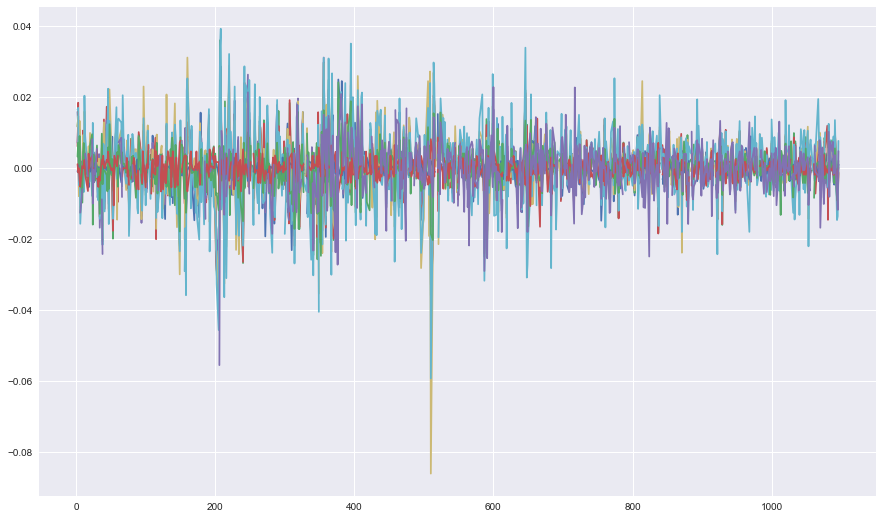

In [9]:
plt.figure(figsize=(15,9)) 
for ETF in basket:
    plt.plot(diff_sincebegin.index.values,diff_sincebegin[ETF])
    
plt.show()

In [20]:
corr = diff_sincebegin.astype(float).corr()

In [21]:
corr

,C.XIC,VTI,C.VUS,C.PDF,IEFA,IEMG,C.XSH,C.ZHY,C.ZFM,C.PHR
C.XIC,1.000000,0.744690,0.719550,0.818341,0.692519,0.700969,-0.070057,0.530026,-0.238725,0.394557
VTI,0.744690,1.000000,0.962794,0.772041,0.827925,0.775213,-0.122263,0.551804,-0.280328,0.451337
C.VUS,0.719550,0.962794,1.000000,0.754506,0.804229,0.750333,-0.143871,0.525583,-0.281819,0.477694
C.PDF,0.818341,0.772041,0.754506,1.000000,0.706909,0.681504,-0.060228,0.508603,-0.126651,0.559705
IEFA,0.692519,0.827925,0.804229,0.706909,1.000000,0.841617,-0.097934,0.527614,-0.259651,0.363991
IEMG,0.700969,0.775213,0.750333,0.681504,0.841617,1.000000,-0.098126,0.543626,-0.202228,0.367742
C.XSH,-0.070057,-0.122263,-0.143871,-0.060228,-0.097934,-0.098126,1.000000,-0.042854,0.433270,0.051479
C.ZHY,0.530026,0.551804,0.525583,0.508603,0.527614,0.543626,-0.042854,1.000000,-0.135728,0.317321
C.ZFM,-0.238725,-0.280328,-0.281819,-0.126651,-0.259651,-0.202228,0.433270,-0.135728,1.000000,0.011110
C.PHR,0.394557,0.451337,0.477694,0.559705,0.363991,0.367742,0.051479,0.317321,0.011110,1.000000


In [29]:
with open('etf.txt', 'w') as f2:
    for i in diff_sincebegin.columns:
        f2.write("%s " %i)

In [32]:
with open('cov.txt', 'w') as f1:
    for i in range(len(r_bar)):
        for j in range(len(r_bar)):
            f1.write("%s " % diff_sincebegin.columns[i])
            f1.write("%s " % diff_sincebegin.columns[j])
            f1.write("%s\n" % corr.iloc[i,j])

In [31]:
with open('rbar.txt', 'w') as f3:
    for i in range(len(r_bar)):
        f3.write("%s " % diff_sincebegin.columns[i])
        f3.write("%s\n" % r_bar[i])

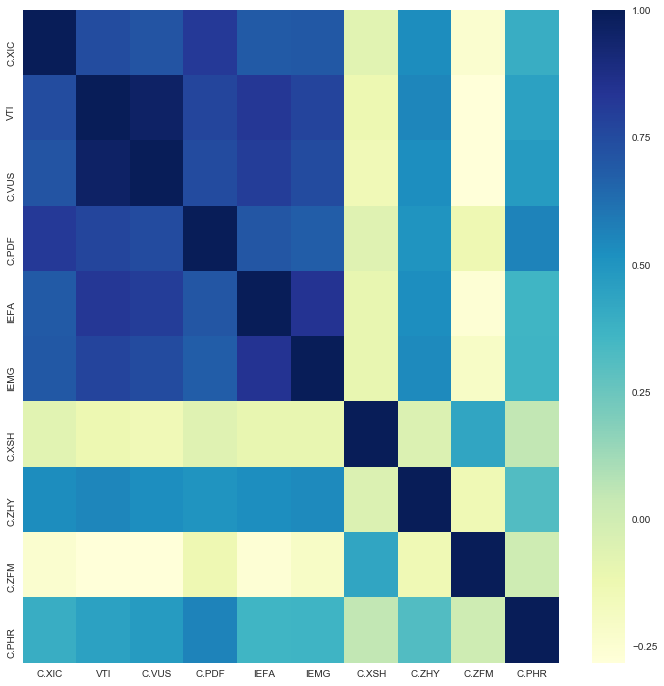

In [33]:
plt.figure(figsize=(12,12))
sns.heatmap(diff_sincebegin.astype(float).corr().values, xticklabels=basket, yticklabels=basket, cmap="YlGnBu")
plt.show()

In [34]:
np.mean(diff_sincebegin)*252

C.XIC    0.035859
VTI      0.119861
C.VUS    0.115491
C.PDF    0.029812
IEFA     0.084331
IEMG     0.105656
C.XSH   -0.017438
C.ZHY   -0.019649
C.ZFM   -0.029662
C.PHR   -0.071311
dtype: float64

In [40]:
begin_date = datetime.date(2015, 1, 31)
for i in basket:
    p_temp = symbolday[i]['close'][symbolday[i].index>begin_date]
    print i, 'has average day2day change ratio (annualized):', (pow(p_temp.iloc[-1]/p_temp.iloc[0],1./3)-1)*100

C.XIC has average day2day change ratio (annualized): 2.42451311308
VTI has average day2day change ratio (annualized): 11.4526607118
C.VUS has average day2day change ratio (annualized): 11.1201211149
C.PDF has average day2day change ratio (annualized): 2.25794936298
IEFA has average day2day change ratio (annualized): 7.18108453098
IEMG has average day2day change ratio (annualized): 8.70475727967
C.XSH has average day2day change ratio (annualized): -1.72011960805
C.ZHY has average day2day change ratio (annualized): -2.39251954902
C.ZFM has average day2day change ratio (annualized): -2.96280806032
C.PHR has average day2day change ratio (annualized): -5.54961636554
